In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 超参数设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设备选择
latent_size = 100  # 潜在向量z的大小
hidden_size = 64  # Generator和Discriminator的隐藏层大小
image_size = 28  # 图像大小
batch_size = 64  # 批次大小
num_epochs = 3  # 训练轮数
learning_rate = 0.002  # 学习率


In [2]:
# 生成器网络
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, hidden_size * 4, 4, 1, 0),
            nn.BatchNorm2d(hidden_size * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size * 4, hidden_size * 2, 3, 2, 1),
            nn.BatchNorm2d(hidden_size * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size * 2, hidden_size, 4, 2, 1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


# 鉴别器网络
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(1, hidden_size, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_size, hidden_size * 2, 4, 2, 1),
            nn.BatchNorm2d(hidden_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_size * 2, hidden_size * 4, 3, 2, 1),
            nn.BatchNorm2d(hidden_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_size * 4, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [3]:
# 数据预处理
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_data = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 创建生成器和鉴别器实例
generator = Generator().to(device)
discriminator = Discriminator().to(device)


100%|██████████| 26421880/26421880 [00:00<00:00, 114379160.77it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4676799.49it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 63445440.61it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15141849.22it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, e

In [7]:
# 定义损失函数和优化器
criterion = nn.BCELoss()  # Binary cross entropy loss
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
print(num_epochs)

3


In [8]:
# 训练过程
loss_g = []
loss_d = []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        batch_size = images.size(0)

        # 生成器训练，生成假图像并给予标签“真实”(1)
        z = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = generator(z)
        labels_real = torch.full((batch_size, 1, 1, 1), 1, device=device, dtype=torch.float)
        loss_g_ = criterion(discriminator(fake_images), labels_real)

        # 清空生成器梯度并反向传播，更新参数
        generator.zero_grad()
        loss_g_.backward()
        optimizer_g.step()

        # 鉴别器训练，给予真实图像标签“真实”(1)，给予假图像标签“虚假”(0)
        labels_real = torch.full((batch_size,), 1, device=device, dtype=torch.float)
        labels_fake = torch.full((batch_size,), 0, device=device, dtype=torch.float)
        loss_d_real = criterion(discriminator(images), labels_real.view(batch_size, 1, 1, 1))
        loss_d_fake = criterion(discriminator(fake_images.detach()), labels_fake.view(batch_size, 1, 1, 1))
        loss_d_ = loss_d_real + loss_d_fake

        # 清空鉴别器梯度并反向传播，更新参数
        discriminator.zero_grad()
        loss_d_.backward()
        optimizer_d.step()

        if i % 100 == 0:
            print('Epoch [{}/{}], Batch [{}/{}], Loss_D: {:.4f}, Loss_G: {:.4f}'
                  .format(epoch, num_epochs, i, len(train_loader), loss_d_.item(), loss_g_.item()))
        
        # 记录损失值
        loss_d.append(loss_d_.item())
        loss_g.append(loss_g_.item())

Epoch [0/3], Batch [0/938], Loss_D: 1.4046, Loss_G: 0.6289
Epoch [0/3], Batch [100/938], Loss_D: 0.3950, Loss_G: 2.8536
Epoch [0/3], Batch [200/938], Loss_D: 0.3595, Loss_G: 3.4632
Epoch [0/3], Batch [300/938], Loss_D: 1.1313, Loss_G: 1.1941
Epoch [0/3], Batch [400/938], Loss_D: 0.6262, Loss_G: 1.9954
Epoch [0/3], Batch [500/938], Loss_D: 0.4775, Loss_G: 2.0432
Epoch [0/3], Batch [600/938], Loss_D: 0.7364, Loss_G: 2.1682
Epoch [0/3], Batch [700/938], Loss_D: 0.6660, Loss_G: 1.5965
Epoch [0/3], Batch [800/938], Loss_D: 0.6179, Loss_G: 1.5795
Epoch [0/3], Batch [900/938], Loss_D: 1.4352, Loss_G: 0.6104
Epoch [1/3], Batch [0/938], Loss_D: 0.7470, Loss_G: 1.5007
Epoch [1/3], Batch [100/938], Loss_D: 0.9982, Loss_G: 1.4399
Epoch [1/3], Batch [200/938], Loss_D: 0.9189, Loss_G: 0.8678
Epoch [1/3], Batch [300/938], Loss_D: 0.8270, Loss_G: 2.4117
Epoch [1/3], Batch [400/938], Loss_D: 0.7030, Loss_G: 2.4083
Epoch [1/3], Batch [500/938], Loss_D: 1.2549, Loss_G: 0.7081
Epoch [1/3], Batch [600/938]

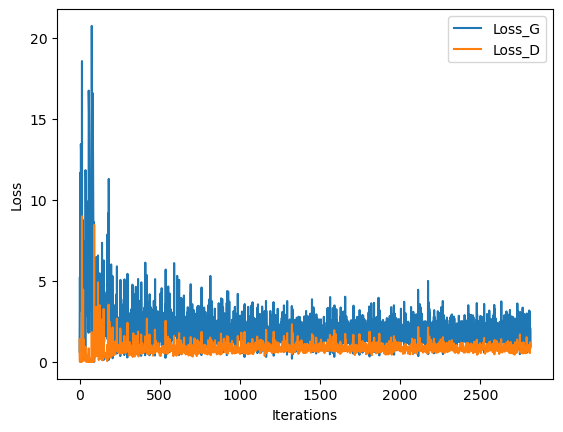

In [9]:
# 画出损失曲线
plt.plot(loss_g, label='Loss_G')
plt.plot(loss_d, label='Loss_D')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

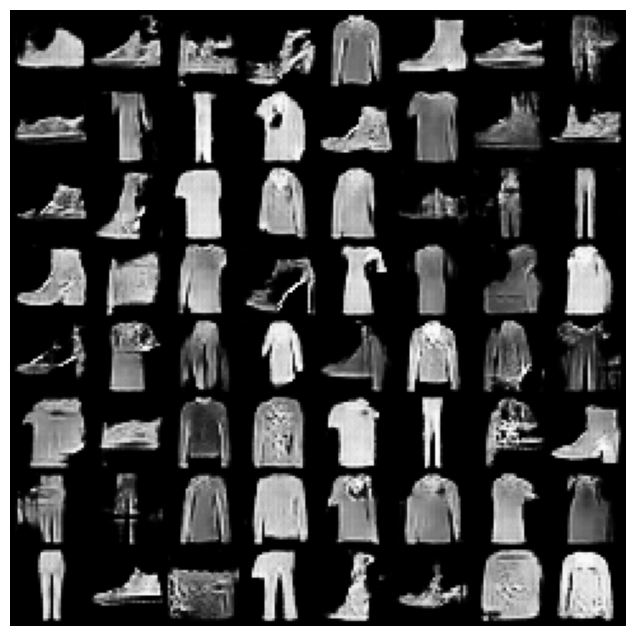

In [10]:
# 展示生成效果
generator.eval()
z = torch.randn(64, latent_size, 1, 1, device=device)
fake_images = generator(z)
fake_images = (fake_images + 1) / 2
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
grid = utils.make_grid(fake_images.cpu(), nrow=8, padding=2, normalize=True)
plt.imshow(grid.permute(1, 2, 0))
plt.show()
